# Explore the psf.cat files 

In [3]:
import astropy
from astropy.io import fits

# Open the FITS file and examine its structure
with fits.open('DRACO_DWARF/reduced/20251017135-101-RA.wcs.proc.fits.psf.cat') as hdul:
    print("FITS File Structure:")
    print("=" * 50)
    
    # Print basic file info
    print(f"Number of HDUs (extensions): {len(hdul)}")
    print()
    
    # Print information about each HDU
    for i, hdu in enumerate(hdul):
        print(f"HDU {i}: {type(hdu).__name__}")
        print(f"  Name: {hdu.name}")
        print(f"  Shape: {hdu.shape if hasattr(hdu, 'shape') else 'N/A'}")
        
        if hasattr(hdu, 'data') and hdu.data is not None:
            print(f"  Data type: {type(hdu.data)}")
            if hasattr(hdu.data, 'shape'):
                print(f"  Data shape: {hdu.data.shape}")
        
        # Print some key header keywords
        if hasattr(hdu, 'header'):
            print("  Key header keywords:")
            for key in ['EXTNAME', 'NAXIS', 'NAXIS1', 'NAXIS2', 'TFIELDS', 'TTYPE1', 'TTYPE2']:
                if key in hdu.header:
                    print(f"    {key}: {hdu.header[key]}")
        
        print()
    
    # Print detailed information about the main data extension
    if len(hdul) > 1:
        main_hdu = hdul[1]  # Usually the second HDU contains the main data
        if hasattr(main_hdu, 'data') and main_hdu.data is not None:
            print("Main Data Extension Details:")
            print("=" * 30)
            print(f"Number of sources: {len(main_hdu.data)}")
            print(f"Number of columns: {len(main_hdu.data.dtype.names)}")
            """
            print("\nColumn names and types:")
            for i, (name, dtype) in enumerate(zip(main_hdu.data.dtype.names, main_hdu.data.dtype)):
                print(f"  {i+1:2d}. {name:20s} ({dtype})")
            """

    # Print detailed information about the main data extension
    if len(hdul) > 2:
        hdu = hdul[2]  # Usually the second HDU contains the main data
        if hasattr(hdu, 'data') and hdu.data is not None:
            print("Data Extension Details:")
            print("=" * 30)
            print(f"Number of sources: {len(hdu.data)}")
            print(f"Number of columns: {len(hdu.data.dtype.names)}")
            print("\nColumn names and types:")
            for i, (name) in enumerate(hdu.data.dtype.names):
                print(f"  {i+1:2d}. {name:20s})")
            



FITS File Structure:
Number of HDUs (extensions): 3

HDU 0: PrimaryHDU
  Name: PRIMARY
  Shape: ()
  Key header keywords:
    NAXIS: 0

HDU 1: BinTableHDU
  Name: LDAC_IMHEAD
  Shape: N/A
  Data type: <class 'astropy.io.fits.fitsrec.FITS_rec'>
  Data shape: (1,)
  Key header keywords:
    EXTNAME: LDAC_IMHEAD
    NAXIS: 2
    NAXIS1: 19520
    NAXIS2: 1
    TFIELDS: 1
    TTYPE1: Field Header Card

HDU 2: BinTableHDU
  Name: LDAC_OBJECTS
  Shape: N/A
  Data type: <class 'astropy.io.fits.fitsrec.FITS_rec'>
  Data shape: (46,)
  Key header keywords:
    EXTNAME: LDAC_OBJECTS
    NAXIS: 2
    NAXIS1: 3053
    NAXIS2: 46
    TFIELDS: 31
    TTYPE1: VIGNET
    TTYPE2: X_IMAGE

Main Data Extension Details:
Number of sources: 1
Number of columns: 1
Data Extension Details:
Number of sources: 46
Number of columns: 31

Column names and types:
   1. VIGNET              )
   2. X_IMAGE             )
   3. Y_IMAGE             )
   4. XWIN_IMAGE          )
   5. YWIN_IMAGE          )
   6. ERRAWIN_I

In [4]:
import os
import pandas as pd
from astropy.io import fits
import numpy as np

# Define paths
input_dir = "DRACO_DWARF/reduced"
output_dir = "output"
    
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
    
# Find all .psf.cat files
psf_files = []
for file in os.listdir(input_dir):
    if file.endswith('.psf.cat'):
        psf_files.append(os.path.join(input_dir, file))
    
print(f"Found {len(psf_files)} .psf.cat files")
    
all_data = []
    
for psf_file in psf_files:
    obs_identifier = os.path.basename(psf_file)[:15]
    print(f"Processing: {os.path.basename(psf_file)}:{obs_identifier}")
        
    try:
        psf_zp = 0
        filter = None
        orig_fits_file = psf_file.replace('.psf.cat', '')
        # Read the PSF_ZP header from the original FITS file
        with fits.open(orig_fits_file) as hdul:
            psf_zp = hdul[0].header.get('PSF_ZP')
            filter = hdul[0].header.get('FILTER')
            print(f"PSF_ZP value: {psf_zp}, FILTER= {filter}")
                    
        # Read the FITS file
        with fits.open(psf_file) as hdul:# Get the main data extension (HDU 2)
            catalog_data = hdul[2].data
    
            # Create a dictionary to store the data, handling multi-dimensional arrays
            data_dict = {}
            
            # Process each column
            for col_name in catalog_data.dtype.names:
                col_data = catalog_data[col_name]
                
                # Check if the column contains multi-dimensional arrays
                if col_data.ndim > 1:
                    # For multi-dimensional arrays (like VIGNET), we'll skip them for CSV
                    #print(f"Skipping column '{col_name}' - contains multi-dimensional data (shape: {col_data.shape})")
                    continue
                else:
                    # For 1D arrays, add to our data dictionary
                    data_dict[col_name] = col_data
            
            # Convert to pandas DataFrame
            df = pd.DataFrame(data_dict)
            df['FILTER'] = filter
            df['PSF_ZP'] = psf_zp
            df['OBS_IDENTIFIER'] = obs_identifier
            # Display basic info about the DataFrame
            #print(f"DataFrame shape: {df.shape}")
            #print(f"Columns: {list(df.columns)}")
            #print(f"\nFirst few rows:")
            #print(df.head())
            
            # Write to CSV file
            output_filename = psf_file.replace('.psf.cat', '.catalog.csv').replace('DRACO_DWARF/reduced', 'output')
            df.to_csv(output_filename, index=False)
            
            print(f"\nCatalog data written to: {output_filename}")
            #print(f"Total sources: {len(df)}")
            #print(f"Total columns: {len(df.columns)}")
    except Exception as e:
        print(f"  - Error processing {psf_file}: {str(e)}")


Found 12 .psf.cat files
Processing: 20251017140-542-RA.wcs.proc.fits.psf.cat:20251017140-542
PSF_ZP value: 26.481975967407227, FILTER= g

Catalog data written to: output/20251017140-542-RA.wcs.proc.fits.catalog.csv
Processing: 20251017135-812-RA.wcs.proc.fits.psf.cat:20251017135-812
PSF_ZP value: 25.39295352783203, FILTER= i

Catalog data written to: output/20251017135-812-RA.wcs.proc.fits.catalog.csv
Processing: 20251017143-456-RA.wcs.proc.fits.psf.cat:20251017143-456
PSF_ZP value: 26.537058545684815, FILTER= g

Catalog data written to: output/20251017143-456-RA.wcs.proc.fits.catalog.csv
Processing: 20251017151-115-RA.wcs.proc.fits.psf.cat:20251017151-115
PSF_ZP value: 25.381746238708494, FILTER= i

Catalog data written to: output/20251017151-115-RA.wcs.proc.fits.catalog.csv
Processing: 20251017142-022-RA.wcs.proc.fits.psf.cat:20251017142-022
PSF_ZP value: 26.53699850463867, FILTER= g

Catalog data written to: output/20251017142-022-RA.wcs.proc.fits.catalog.csv
Processing: 20251017141

In [5]:
import pandas as pd
import numpy as np
import os

# Define the g-band to i-band mapping
g_to_i = {
    '20251017135-101': '20251017135-812',
    '20251017140-542': '20251017141-300',
    '20251017142-022': '20251017142-734',
    '20251017143-456': '20251017144-208',
    '20251017144-929': '20251017145-642',
    '20251017150-403': '20251017151-115'
}

# Create output directory if it doesn't exist
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Initialize list to store all matched data
all_matches = []

# Process each g-band to i-band pair
for g_key, i_key in g_to_i.items():
    print(f"Processing pair: {g_key} (g-band) -> {i_key} (i-band)")
    
    try:
        # Load g-band CSV file
        g_file = f"output/{g_key}-RA.wcs.proc.fits.catalog.csv"
        g_df = pd.read_csv(g_file)
        
        # Load i-band CSV file  
        i_file = f"output/{i_key}-RA.wcs.proc.fits.catalog.csv"
        i_df = pd.read_csv(i_file)
        
        # Select only the required columns
        required_cols = ['ALPHAWIN_J2000', 'DELTAWIN_J2000', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'PSF_ZP']
        
        g_df_subset = g_df[required_cols].copy()
        i_df_subset = i_df[required_cols].copy()
        
        print(f"G-band sources: {len(g_df_subset)}")
        print(f"I-band sources: {len(i_df_subset)}")
        
        # Calculate coordinate ranges for normalization
        alpha_range = (g_df_subset['ALPHAWIN_J2000'].max() - g_df_subset['ALPHAWIN_J2000'].min() + 
                      i_df_subset['ALPHAWIN_J2000'].max() - i_df_subset['ALPHAWIN_J2000'].min())
        delta_range = (g_df_subset['DELTAWIN_J2000'].max() - g_df_subset['DELTAWIN_J2000'].min() + 
                      i_df_subset['DELTAWIN_J2000'].max() - i_df_subset['DELTAWIN_J2000'].min())
        
        # Create a copy of i_df_subset for tracking remaining records
        i_df_remaining = i_df_subset.copy()
        
        # For each record in g-band, find the best match in i-band
        MAX_MATCH_DISTANCE = 1e-3
        
        for g_idx, g_row in g_df_subset.iterrows():
            g_ra = g_row['ALPHAWIN_J2000']
            g_dec = g_row['DELTAWIN_J2000']
            
            if len(i_df_remaining) == 0:
                break
            
            # Calculate distances for all remaining i-band sources
            distances = np.sqrt(
                ((i_df_remaining['ALPHAWIN_J2000'] - g_ra)/alpha_range)**2 + 
                ((i_df_remaining['DELTAWIN_J2000'] - g_dec)/delta_range)**2
            )
            
            # Find the index of the closest match
            best_i_idx = distances.idxmin()
            best_distance = distances.min()
            
            if best_distance < MAX_MATCH_DISTANCE:
                # Get the best matching i-band record
                i_row = i_df_remaining.loc[best_i_idx]
                
                # Calculate magnitudes and color
                g_mag = g_row['MAG_POINTSOURCE'] + g_row['PSF_ZP']
                i_mag = i_row['MAG_POINTSOURCE'] + i_row['PSF_ZP']
                color = g_mag - i_mag
                mag_err = g_row['MAGERR_POINTSOURCE'] + i_row['MAGERR_POINTSOURCE']
                
                # Calculate average coordinates
                ra = 0.5 * (g_row['ALPHAWIN_J2000'] + i_row['ALPHAWIN_J2000'])
                dec = 0.5 * (g_row['DELTAWIN_J2000'] + i_row['DELTAWIN_J2000'])
                
                # Store the match
                all_matches.append({
                    'g_key': g_key,
                    'i_key': i_key,
                    'ra': ra,
                    'dec': dec,
                    'g_mag': g_mag,
                    'i_mag': i_mag,
                    'color': color,
                    'mag_err': mag_err,
                    'match_distance': best_distance,
                })
                
                # Remove the matched record from remaining i-band sources
                i_df_remaining = i_df_remaining.drop(best_i_idx)
        
        print(f"Matches found: {len([m for m in all_matches if m['g_key'] == g_key])}")
        
    except FileNotFoundError as e:
        print(f"Error: Could not find file - {e}")
    except Exception as e:
        print(f"Error processing {g_key} -> {i_key}: {e}")

# Create DataFrame from all matches
if all_matches:
    color_mag_df = pd.DataFrame(all_matches)
    
    # Save to CSV
    output_file = "output/color_mag.csv"
    color_mag_df.to_csv(output_file, index=False)
    
    print(f"\nConsolidated color_mag.csv created with {len(color_mag_df)} sources")
    print(f"File saved to: {output_file}")
    print(f"\nColumns: {list(color_mag_df.columns)}")
    print(f"\nFirst few rows:")
    print(color_mag_df.head())
else:
    print("No matches found to create consolidated file")

Processing pair: 20251017135-101 (g-band) -> 20251017135-812 (i-band)
G-band sources: 46
I-band sources: 47
Matches found: 45
Processing pair: 20251017140-542 (g-band) -> 20251017141-300 (i-band)
G-band sources: 39
I-band sources: 41
Matches found: 34
Processing pair: 20251017142-022 (g-band) -> 20251017142-734 (i-band)
G-band sources: 48
I-band sources: 52
Matches found: 45
Processing pair: 20251017143-456 (g-band) -> 20251017144-208 (i-band)
G-band sources: 52
I-band sources: 53
Matches found: 45
Processing pair: 20251017144-929 (g-band) -> 20251017145-642 (i-band)
G-band sources: 38
I-band sources: 46
Matches found: 36
Processing pair: 20251017150-403 (g-band) -> 20251017151-115 (i-band)
G-band sources: 38
I-band sources: 40
Matches found: 34

Consolidated color_mag.csv created with 239 sources
File saved to: output/color_mag.csv

Columns: ['g_key', 'i_key', 'ra', 'dec', 'g_mag', 'i_mag', 'color', 'mag_err', 'match_distance']

First few rows:
             g_key            i_key     

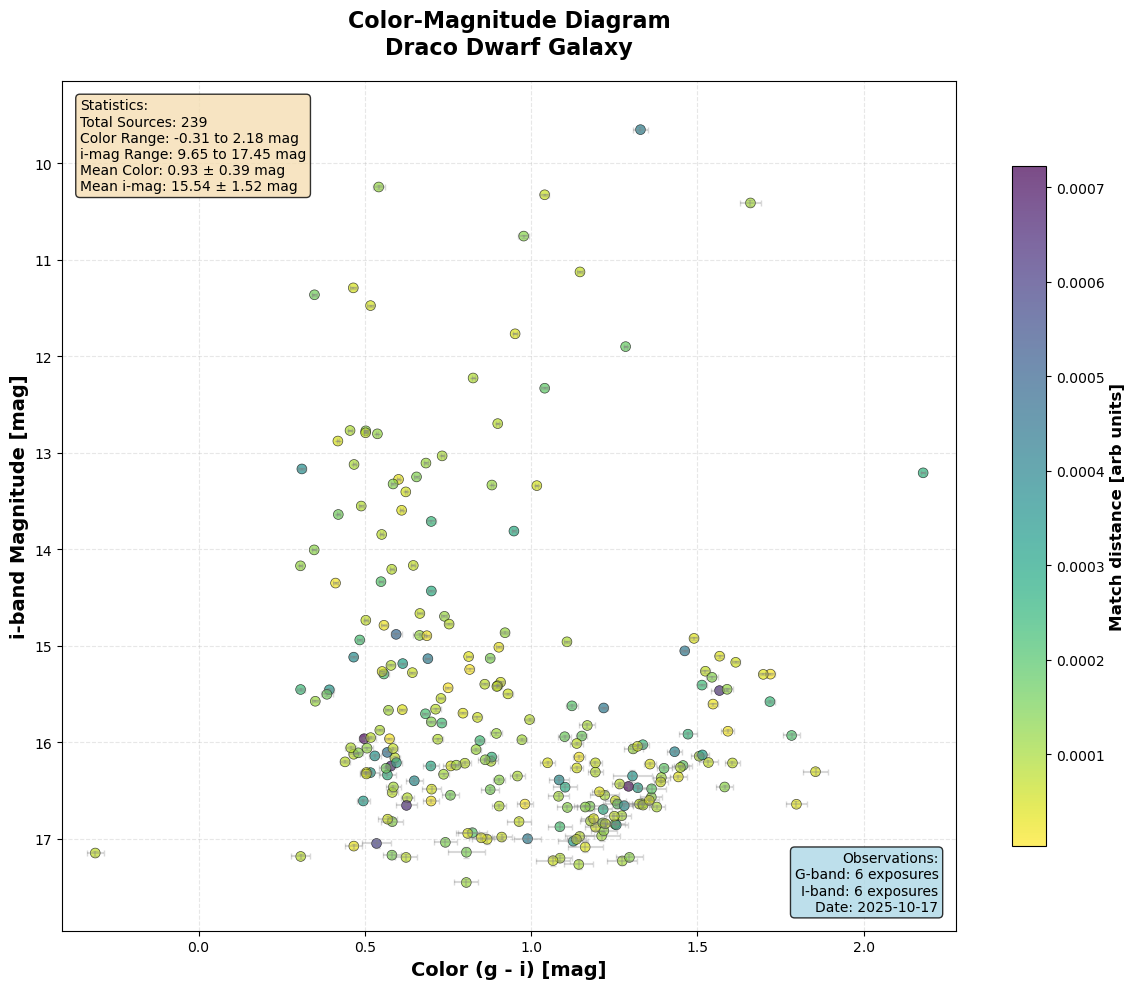

Color-Magnitude Diagram Summary:
Total sources: 239
Color range: -0.310 to 2.179 mag
i-magnitude range: 9.653 to 17.452 mag
Mean color: 0.932 ± 0.389 mag
Mean i-magnitude: 15.540 ± 1.524 mag
Mean magnitude error: 0.020 mag


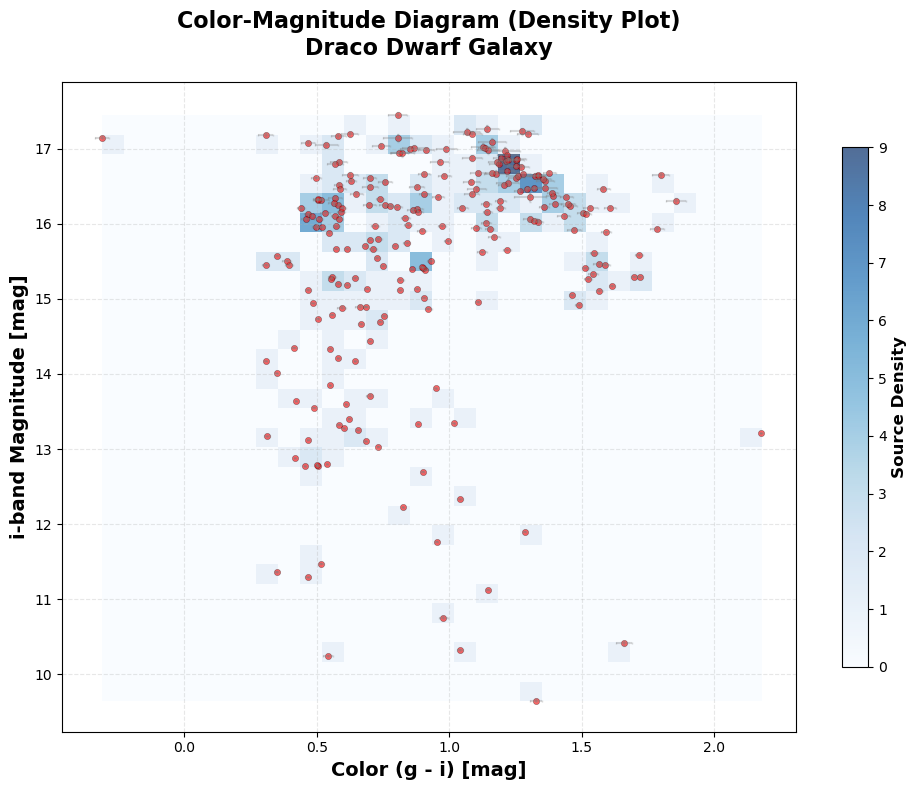

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Load the color-magnitude data
df = pd.read_csv('output/color_mag.csv')

# Create a professional color-magnitude diagram
fig, ax = plt.subplots(figsize=(12, 10))

# Set up the plot with proper astronomical conventions
# In astronomy, magnitude increases downward (fainter objects are higher numbers)
# So we'll invert the y-axis

# Create scatter plot with error bars
scatter = ax.scatter(df['color'], df['i_mag'], 
                    c=df['match_distance'], 
                    s=50, 
                    alpha=0.7, 
                    cmap='viridis_r',
                    edgecolors='black',
                    linewidth=0.5)

# Add error bars
ax.errorbar(df['color'], df['i_mag'], 
           xerr=df['mag_err'], 
           yerr=df['mag_err'],
           fmt='none', 
           alpha=0.3, 
           color='gray',
           capsize=2)

# Customize the plot
ax.set_xlabel('Color (g - i) [mag]', fontsize=14, fontweight='bold')
ax.set_ylabel('i-band Magnitude [mag]', fontsize=14, fontweight='bold')
ax.set_title('Color-Magnitude Diagram\nDraco Dwarf Galaxy', fontsize=16, fontweight='bold', pad=20)

# Invert y-axis (astronomical convention: brighter = lower magnitude)
ax.invert_yaxis()

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

# Set axis limits with some padding
ax.set_xlim(df['color'].min() - 0.1, df['color'].max() + 0.1)
ax.set_ylim(df['i_mag'].max() + 0.5, df['i_mag'].min() - 0.5)

# Add colorbar for magnitude errors
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Match distance [arb units]', fontsize=12, fontweight='bold')

# Add statistics text box
stats_text = f"""Statistics:
Total Sources: {len(df)}
Color Range: {df['color'].min():.2f} to {df['color'].max():.2f} mag
i-mag Range: {df['i_mag'].min():.2f} to {df['i_mag'].max():.2f} mag
Mean Color: {df['color'].mean():.2f} ± {df['color'].std():.2f} mag
Mean i-mag: {df['i_mag'].mean():.2f} ± {df['i_mag'].std():.2f} mag"""

# Add text box with statistics
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Add observation details
obs_text = f"""Observations:
G-band: {df['g_key'].nunique()} exposures
I-band: {df['i_key'].nunique()} exposures
Date: 2025-10-17"""

ax.text(0.98, 0.02, obs_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('output/color_magnitude_diagram.png', dpi=300, bbox_inches='tight')
plt.savefig('output/color_magnitude_diagram.pdf', bbox_inches='tight')

# Show the plot
plt.show()

# Print summary statistics
print("Color-Magnitude Diagram Summary:")
print("=" * 50)
print(f"Total sources: {len(df)}")
print(f"Color range: {df['color'].min():.3f} to {df['color'].max():.3f} mag")
print(f"i-magnitude range: {df['i_mag'].min():.3f} to {df['i_mag'].max():.3f} mag")
print(f"Mean color: {df['color'].mean():.3f} ± {df['color'].std():.3f} mag")
print(f"Mean i-magnitude: {df['i_mag'].mean():.3f} ± {df['i_mag'].std():.3f} mag")
print(f"Mean magnitude error: {df['mag_err'].mean():.3f} mag")

# Create a second plot focusing on the main sequence/red giant branch
fig2, ax2 = plt.subplots(figsize=(10, 8))

# Create a 2D histogram for better visualization of density
H, xedges, yedges = np.histogram2d(df['color'], df['i_mag'], bins=30)
extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]  # Note: yedges inverted for astronomical convention

# Plot 2D histogram
im = ax2.imshow(H.T, extent=extent, aspect='auto', cmap='Blues', alpha=0.7)

# Overlay scatter plot
ax2.scatter(df['color'], df['i_mag'], 
           c='red', s=20, alpha=0.6, edgecolors='black', linewidth=0.3)

# Add error bars
ax2.errorbar(df['color'], df['i_mag'], 
            xerr=df['mag_err'], 
            yerr=df['mag_err'],
            fmt='none', alpha=0.3, color='gray', capsize=1)

ax2.set_xlabel('Color (g - i) [mag]', fontsize=14, fontweight='bold')
ax2.set_ylabel('i-band Magnitude [mag]', fontsize=14, fontweight='bold')
ax2.set_title('Color-Magnitude Diagram (Density Plot)\nDraco Dwarf Galaxy', 
              fontsize=16, fontweight='bold', pad=20)

# Invert y-axis
ax2.invert_yaxis()

# Add grid
ax2.grid(True, alpha=0.3, linestyle='--')

# Add colorbar for density
cbar2 = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar2.set_label('Source Density', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('output/color_magnitude_density.png', dpi=300, bbox_inches='tight')
plt.savefig('output/color_magnitude_density.pdf', bbox_inches='tight')
plt.show()